<a href="https://colab.research.google.com/github/Raahee1729/PyCBC-Tuts-and-Examples/blob/main/SNR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SNR :-

1. choose the event and the detector
2. set lowset freq threshold
3. the time vs strain data
To generate the therotical waveform of merger
4. set m1,s1 and m2,s2 as parameters
5. use the form to get the template
hp, hc = get_td_waveform

(

    approximant=...,      # Name of the waveform model (string)
    mass1=...,            # Mass of the first object (in solar masses)
    mass2=...,            # Mass of the second object (in solar masses)
    spin1z=...,           # z-component of spin for the first object
    spin2z=...,           # z-component of spin for the second object
    f_lower=...,          # Starting frequency of the waveform (Hz)
    delta_t=...           # Time step between samples (sec)


)
6. plot is time vs hp
7. resize and compare it with the data from H1
8. get its PDS
9. computes its SNR
10. plot is as the SNR evolves with time



In [ ]:
# Install PyCBC and downgrade NumPy
!pip install -q numpy==1.23.5
!pip install -q pycbc

# Restart the runtime to finalize NumPy change
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.1

In [ ]:
#download the data
!curl -O -J https://raw.githubusercontent.com/ligo-cbc/binder/master/H-H1_LOSC_4_V2-1126259446-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     65      0 --:--:-- --:--:-- --:--:--    65


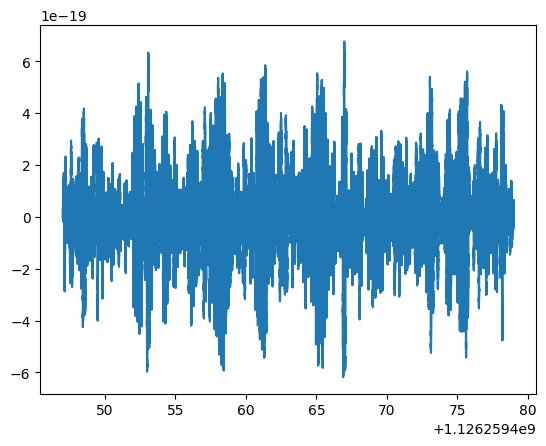

In [ ]:
# Import the functions we need for later!
%matplotlib inline
import pylab
from pycbc.catalog import Merger
from pycbc.filter import highpass_fir, matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.psd import welch, interpolate

# Read the Hanford data and remove low frequency content
h1 = Merger("GW150914").strain("H1") #Loads the strain time series data from the Hanford (H1) detector for the GW150914 event.
h1 = highpass_fir(h1, 15, 16)         # 15 is the curoff frequncy, 16 is filter order

# Can you spot where the signal is beforehand?
pylab.plot(h1.sample_times, h1)

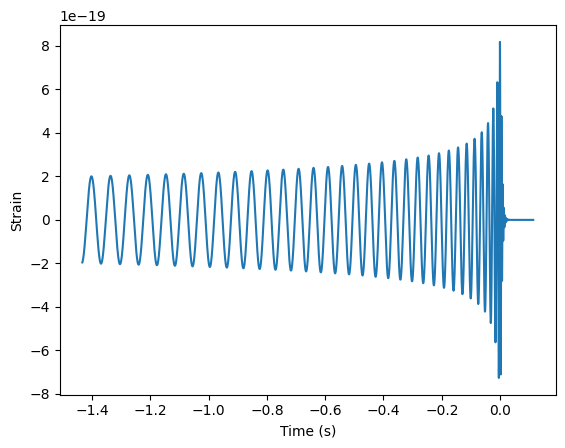

In [ ]:
# Generate a waveform similar to GW150914
# Change the parameters and see what happens to the waveform
# and the resulting SNR.

# Mass in Solar masses.
m1 = 35.2
m2 = 34.0

# The intrinsic spin of each black hole
s1z = -0.228
s2z = -0.003
# The frequency to start generating the waveform
fstart = 15.0

hp, hc = get_td_waveform(approximant="SEOBNRv2",
                         mass1=m1, spin1z=s1z,
                         mass2=m2, spin2z=s2z,
                         f_lower=fstart,
                         delta_t=h1.delta_t)
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

# Move the waveform so that the merge is about at the end
# This means that an SNR spike later on in the data lines up with this point
hp.resize(len(h1))                                # Resizes the generated waveform hp to match the length of the Hanford strain data h1
hp.roll(int(hp.start_time * hp.sample_rate))

Text(0.5, 0, 'Frequency (Hz)')

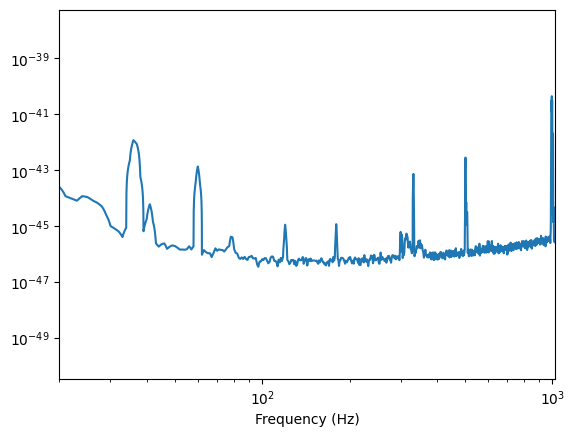

In [ ]:
# Estimate the noise spectrum
# Normally we use more data to estimate the psd, but this is illustrative
psd = interpolate(welch(h1), 1.0 / h1.duration) # welch method

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(20, 1024)
pylab.xlabel('Frequency (Hz)')

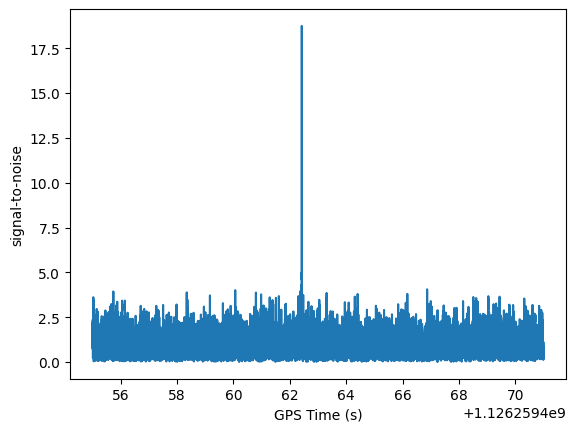

In [ ]:
# Calculate the complex Signal-to-noise. This is a complex vector
# because the signal could have any phase.
snr = matched_filter(hp, h1, psd=psd, low_frequency_cutoff=30.0)

# Remove regions corrupted by filter wraparound
# get only the middle part
snr = snr[len(snr) // 4: len(snr) * 3 // 4]

# Now you should be able to spot where the signal is!
pylab.plot(snr.sample_times, abs(snr)) # this function compares the data with the template
                                      # SNR as time evolves VS the SNR
pylab.ylabel('signal-to-noise')
pylab.xlabel('GPS Time (s)')
pylab.show()